In [34]:
#Import all necessary packages
import gurobipy as gp
from gurobipy import GRB

In [2]:
from gerrychain import Graph
import networkx as nx

In [3]:
import geopandas as gpd
import math

In [25]:
#Set filepath and filename equal to the path/name of the data
filepath = 'C:/Users/zacha/OR Project/'
filename= 'AR_county.json'

#Create Graph object G from file
G = Graph.from_json(filepath + filename)

<bound method Graph.number_of_nodes of <Graph [75 nodes, 192 edges]>>


In [24]:
#This will set each node in G equal to the population of its respective county
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [6]:
#Print each node, the county it represents, and their 2020 population
for node in G.nodes:
    name = G.nodes[node]['NAME20']
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County with 2020 population of",population)

Node 0 represents Franklin County with 2020 population of 17097
Node 1 represents Crawford County with 2020 population of 60133
Node 2 represents Jackson County with 2020 population of 16755
Node 3 represents Clay County with 2020 population of 14552
Node 4 represents Faulkner County with 2020 population of 123498
Node 5 represents Baxter County with 2020 population of 41627
Node 6 represents Little River County with 2020 population of 12026
Node 7 represents Boone County with 2020 population of 37373
Node 8 represents Ashley County with 2020 population of 19062
Node 9 represents Desha County with 2020 population of 11395
Node 10 represents St. Francis County with 2020 population of 23090
Node 11 represents Montgomery County with 2020 population of 8484
Node 12 represents Sharp County with 2020 population of 17271
Node 13 represents Greene County with 2020 population of 45736
Node 14 represents Woodruff County with 2020 population of 6269
Node 15 represents White County with 2020 popul

In [8]:
#Set the ceiling and floor of the model equal to the maximum deviation/2 * the average population
dev = 0.01

k = 4
tot_pop = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-dev/2)*tot_pop/k)
U = math.floor((1+dev/2)*tot_pop/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [9]:
#Create a new model object and variables
m = gp.Model()

x = m.addVars(G.nodes, k, vtype=GRB.BINARY)
y = m.addVars(G.edges, vtype=GRB.BINARY)

Restricted license - for non-production use only - expires 2024-10-28


In [10]:
#Set objective to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [11]:
#Constraint that each county i is assigned to a district j
m.addConstrs(gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

#Constraint that each district j has a population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k))
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k))

#Constraint that an edge is cut if u is assigned to district j but v is not
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))
m.update()

In [26]:
#Add root variables: r[i,j] equals 1 if node i is the root of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

import networkx as nx 

DG = nx.DiGraph(G)

f = m.addVars(DG.edges)

In [13]:
#The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

#Constraint that each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

#Constraint that if node i isn't assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) )

#If not a root, consume some flow
#If a root, only send out (so much) flow
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )
#Do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1-y[i,j] )for i,j in G.edges)

m.update()

In [14]:
#Solve IP model
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xa1a4a853
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.01s
Presolved: 1422 rows, 1176 columns, 5748 nonzeros
Variable types: 384 continuous, 792 integer (792 binary)

Root relaxation: objective 0.000000e+00, 581 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  316          -    0.00000      -     -    0s
     0     0

 212956 38639   33.67998   34  171   35.00000   27.43373  21.6%   110  385s
 215212 38910   33.57026   37  214   35.00000   27.47235  21.5%   110  390s
 218612 39311   30.81987   28  177   35.00000   27.52761  21.3%   110  396s
 220774 39559   30.85416   31  304   35.00000   27.56185  21.3%   110  400s
 223231 39869   33.09821   34  165   35.00000   27.59688  21.2%   110  405s
 226414 40259     cutoff   33        35.00000   27.64101  21.0%   110  411s
 228968 40554   32.08809   30  255   35.00000   27.68126  20.9%   110  415s
H229420 37087                      34.0000000   27.68288  18.6%   110  415s
 231153 37130   32.39486   31  280   34.00000   27.71914  18.5%   110  420s
 232054 37226   30.21352   32  259   34.00000   27.73851  18.4%   110  425s
 234523 37351     cutoff   31        34.00000   27.78230  18.3%   110  430s
 237604 37451   32.57417   34  180   34.00000   27.83932  18.1%   110  436s
 240046 37467     cutoff   36        34.00000   27.88511  18.0%   110  440s
 243312 3753

In [15]:
print("The number of cut edges is",m.objval)

#Retrieve each district and its population
districts = [[i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

#Print it along with counties it contains
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 1 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun', 'Phillips']

District 2 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 3 has population 750788 and contain

In [33]:
#Read Arkansas county shapefile from "AR_county.shp"
filepath = 'C:/Users/zacha/OR Project/'
filename = 'AR_county.shp'

#Read geopandas dataframe from file
df = gpd.read_file( filepath + filename)

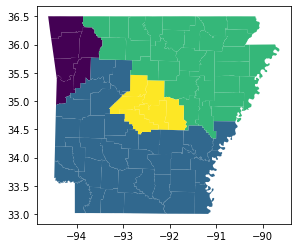

In [28]:
#Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

#Now add the assignments to a column of the dataframe and map
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

#Pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    #What node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    #Position u in the dataframe should be given
    #The same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
#Now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()